In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import (
    compute_new_pose,
    poses_to_diff
)

In [3]:
# Initialize VJEPA 2-AC model
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")

# Initialize transform
crop_size = 256
tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)

Using cache found in /home/yinzi/.cache/torch/hub/facebookresearch_vjepa2_main
/nvmessd/yinzi/vjepa2/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
encoder

VisionTransformer(
  (patch_embed): PatchEmbed3D(
    (proj): Conv3d(3, 1408, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (blocks): ModuleList(
    (0-39): 40 x Block(
      (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (attn): RoPEAttention(
        (qkv): Linear(in_features=1408, out_features=4224, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1408, out_features=1408, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1408, out_features=6144, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=6144, out_features=1408, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
)

In [5]:
predictor

VisionTransformerPredictorAC(
  (predictor_embed): Linear(in_features=1408, out_features=1024, bias=True)
  (action_encoder): Linear(in_features=7, out_features=1024, bias=True)
  (state_encoder): Linear(in_features=7, out_features=1024, bias=True)
  (extrinsics_encoder): Linear(in_features=6, out_features=1024, bias=True)
  (predictor_blocks): ModuleList(
    (0-23): 24 x ACBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): ACRoPEAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4

In [6]:
# Load robot trajectory

play_in_reverse = False  # Use this FLAG to try loading the trajectory backwards, and see how the energy landscape changes

trajectory = np.load("franka_example_traj.npz")
np_clips = trajectory["observations"]
np_states = trajectory["states"]
if play_in_reverse:
    np_clips = trajectory["observations"][:, ::-1].copy()
    np_states = trajectory["states"][:, ::-1].copy()
np_actions = np.expand_dims(poses_to_diff(np_states[0, 0], np_states[0, 1]), axis=(0, 1))

# Convert trajectory to torch tensors
clips = transform(np_clips[0]).unsqueeze(0)
states = torch.tensor(np_states)
actions = torch.tensor(np_actions)
print(f"clips: {clips.shape}; states: {states.shape}; actions: {actions.shape}")

clips: torch.Size([1, 3, 2, 256, 256]); states: torch.Size([1, 2, 7]); actions: torch.Size([1, 1, 7])


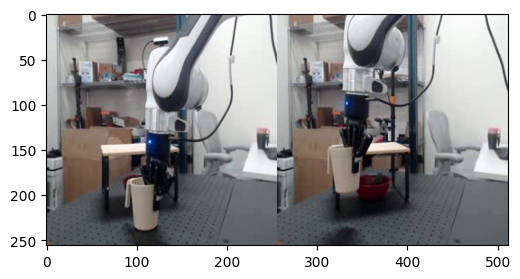

In [7]:
# Visualize loaded video frames from traj

T = len(np_clips[0])
plt.figure(figsize=(20, 3))
_ = plt.imshow(np.transpose(np_clips[0], (1, 0, 2, 3)).reshape(256, 256 * T, 3))

In [8]:
def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h


def forward_actions(z, nsamples, grid_size=0.075, normalize_reps=True, action_repeat=1):

    def make_action_grid(grid_size=grid_size):
        action_samples = []
        for da in np.linspace(-grid_size, grid_size, nsamples):
            for db in np.linspace(-grid_size, grid_size, nsamples):
                for dc in np.linspace(-grid_size, grid_size, nsamples):
                    action_samples += [torch.tensor([da, db, dc, 0, 0, 0, 0], device=z.device, dtype=z.dtype)]
        return torch.stack(action_samples, dim=0).unsqueeze(1)

    # Sample grid of actions
    action_samples = make_action_grid()
    print(f"Sampled grid of actions; num actions = {len(action_samples)}")

    def step_predictor(_z, _a, _s):
        _z = predictor(_z, _a, _s)[:, -tokens_per_frame:]
        if normalize_reps:
            _z = F.layer_norm(_z, (_z.size(-1),))
        _s = compute_new_pose(_s[:, -1:], _a[:, -1:])
        return _z, _s

    # Context frame rep and context pose
    z_hat = z[:, :tokens_per_frame].repeat(int(nsamples**3), 1, 1)  # [S, N, D]
    s_hat = states[:, :1].repeat((int(nsamples**3), 1, 1))  # [S, 1, 7]
    a_hat = action_samples  # [S, 1, 7]

    for _ in range(action_repeat):
        _z, _s = step_predictor(z_hat, a_hat, s_hat)
        z_hat = torch.cat([z_hat, _z], dim=1)
        s_hat = torch.cat([s_hat, _s], dim=1)
        a_hat = torch.cat([a_hat, action_samples], dim=1)

    return z_hat, s_hat, a_hat

def loss_fn(z, h):
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    loss = torch.abs(z - h)  # [B, N, D]
    loss = torch.mean(loss, dim=[1, 2])
    return loss.tolist()

In [13]:
clips.shape

torch.Size([1, 3, 2, 256, 256])

In [11]:
# Compute energy for cartesian action grid of size (nsample x nsamples x nsamples)
nsamples = 5
grid_size = 0.075
with torch.no_grad():
    h = forward_target(clips)
    z_hat, s_hat, a_hat = forward_actions(h, nsamples=nsamples, grid_size=grid_size)
    loss = loss_fn(z_hat, h)  # jepa prediction loss

/home/yinzi/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Sampled grid of actions; num actions = 125


Ground truth action (x,y,z) = (0.09,0.03,0.08)


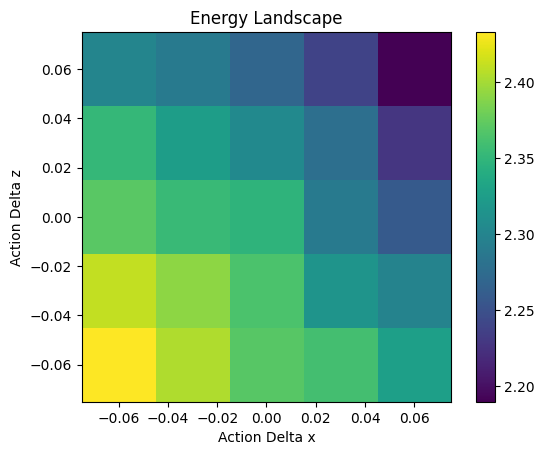

In [12]:
# Plot the energy

plot_data = []
for b, v in enumerate(loss):
    plot_data.append((
        a_hat[b, :-1, 0].sum(),
        a_hat[b, :-1, 1].sum(),
        a_hat[b, :-1, 2].sum(),
        v,
    ))

delta_x = [d[0] for d in plot_data]
delta_y = [d[1] for d in plot_data]
delta_z = [d[2] for d in plot_data]
energy = [d[3] for d in plot_data]

gt_x = actions[0, 0, 0]
gt_y = actions[0, 0, 1]
gt_z = actions[0, 0, 2]

# Create the 2D histogram
heatmap, xedges, yedges = np.histogram2d(delta_x, delta_z, weights=energy, bins=nsamples)

# Set axis labels
plt.xlabel("Action Delta x")
plt.ylabel("Action Delta z")
plt.title(f"Energy Landscape")

# Display the heatmap
print(f"Ground truth action (x,y,z) = ({gt_x:.2f},{gt_y:.2f},{gt_z:.2f})")
_ = plt.imshow(heatmap.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="viridis")
_ = plt.colorbar()

In [17]:
# Compute the optimal action using MPC
from utils.world_model_wrapper import WorldModel

world_model = WorldModel(
    encoder=encoder,
    predictor=predictor,
    tokens_per_frame=tokens_per_frame,
    transform=transform,
    # Doing very few CEM iterations with very few samples just to run efficiently on CPU...
    # ... increase cem_steps and samples for more accurate optimization of energy landscape
    mpc_args={
        "rollout": 2,
        "samples": 25,
        "topk": 10,
        "cem_steps": 2,
        "momentum_mean": 0.15,
        "momentum_mean_gripper": 0.15,
        "momentum_std": 0.75,
        "momentum_std_gripper": 0.15,
        "maxnorm": 0.075,
        "verbose": True
    },
    normalize_reps=True,
    device="cpu"
)

with torch.no_grad():
    h = forward_target(clips)
    z_n, z_goal = h[:, :tokens_per_frame], h[:, -tokens_per_frame:]
    s_n = states[:, :1]
    print(f"Starting planning using Cross-Entropy Method...")
    actions = world_model.infer_next_action(z_n, s_n, z_goal).cpu().numpy()

print(f"Actions returned by planning with CEM (x,y,z) = ({actions[0, 0]:.2f},{actions[0, 1]:.2f} {actions[0, 2]:.2f})")

/home/yinzi/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Starting planning using Cross-Entropy Method...
[INFO    ][2025-07-11 15:38:38][utils.mpc_utils     ][cem                      ] new mean: tensor([0.0292, 0.0357, 0.0517, 0.1426]) tensor([0.1382, 0.1443, 0.1385, 1.3605])
[INFO    ][2025-07-11 15:38:46][utils.mpc_utils     ][cem                      ] new mean: tensor([0.0341, 0.0176, 0.0498, 0.5670]) tensor([0.1281, 0.1367, 0.1241, 1.0093])
Actions returned by planning with CEM (x,y,z) = (0.04,0.02 0.05)


In [14]:
tokens_per_frame

256

In [15]:
h.shape

torch.Size([1, 512, 1408])